In [1]:
# Import the necessary python modules
import pandas as pd # v.1.4.3
import numpy as np # v.1.23.0

from scipy import stats # v.1.10.1
from sklearn import metrics # v.1.2.2

import os
os.add_dll_directory(r"C:\Program Files\R\R-4.3.0\bin\x64") # apparently, current issues require you to add this manually
import rpy2.rinterface as ri # v.3.5.11

from statsmodels.stats.proportion import proportion_confint
import statsmodels.formula.api as smf
from lifelines import KaplanMeierFitter # v.0.27.7
from lifelines.statistics import logrank_test, multivariate_logrank_test

import matplotlib.pyplot as plt # v.3.7.1
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
import seaborn as sns # v.0.12.2

from tqdm import tqdm # v.4.65.0

import random # python v.3.9.0
import math
from itertools import combinations

import warnings
warnings.filterwarnings('ignore') # please feel free to remove this 

In [2]:
# Change the default font of matplotlib to "Arial"
plt.rcParams.update({"font.family":"Arial",})

In [3]:
# Import the table saved after the data extraction
df_pe = pd.read_excel("sec_PE_data/secondary_PE_final.xlsx")

In [4]:
# creating a formatter that can change axes-labels to percent
def to_percent(value, position):
    return f"{value * 100:.0f}%"

percent_formatter = FuncFormatter(to_percent)

# Tables

## Functions

In [5]:
# A function on how to do a Fisher Exact test via R from python as there is no Fisher Exact test 
# implemented in Python for a contigency table larger than 2x2
def fisher_test_from_contingency_table_rinterface(contingency_table):
    """
    Perform a Fisher Exact test via R on a contigency table and return the p-value. This is mainly
    design for larger contigency tables (> 2x2) as a Fisher Exact test for these is not implemented 
    in Python, yet.
    
    :param contingency_table: Dataframe - contingency table
    
    :return: p-value (float)
    
    """
    # Ensure all index and column labels in the contingency table are strings
    contingency_table.index = contingency_table.index.astype(str)
    contingency_table.columns = contingency_table.columns.astype(str)

    # Activate R bindings
    ri.initr()

    # Convert the contingency table to an R-friendly format
    data_values = ri.FloatSexpVector(contingency_table.values.flatten())
    row_labels = ri.StrSexpVector(contingency_table.index.values)
    col_labels = ri.StrSexpVector(contingency_table.columns.values)
    num_rows = contingency_table.shape[0]
    num_cols = contingency_table.shape[1]

    # Define and evaluate the R script
    # The function switches to p-value approximation if the exact p-value calculation exceeds
    # a workspace of 2e7 (for larger contigency tables e.g. 2x9)
    r_script = f"""
    library(stats)

    matrix_r <- matrix(c({','.join(map(str, data_values))}),
                       nrow = {num_rows}, ncol = {num_cols}, byrow = TRUE)
    colnames(matrix_r) <- c({','.join(map(lambda x: f'"{x}"', col_labels))})
    rownames(matrix_r) <- c({','.join(map(lambda x: f'"{x}"', row_labels))})
    contingency_table_r <- as.data.frame(matrix_r)

    tryCatch(
      {{
        result <- fisher.test(contingency_table_r, workspace = 2e7)  # Increase workspace size
        p_value <- result$p.value
        p_value
      }},
      error = function(e){{
        # Catch the workspace error and perform the simulation
        result <- fisher.test(contingency_table_r, simulate.p.value = TRUE)
        p_value <- result$p.value
        p_value
      }}
    )
    """

    # Execute the R script and get the p-value
    p_value = ri.baseenv['eval'](ri.parse(text=r_script))[0]

    # Return the p-value as a float
    return float(p_value)


def agg_binary_count_and_percentage(x):
    """ aggregating function for the binary variables, producing a count and percentage """
    if x.empty:
        return np.nan

    val_cnt = x.dropna().value_counts()

    if 1 not in val_cnt.index:
        return "0 (0%)"

    ones_count = val_cnt.at[1]

    ones_percentage = x.value_counts(normalize=True).at[1] * 100
    ones_percentage = round(ones_percentage, 1)

    return "{} ({}%)".format(ones_count, ones_percentage)


def agg_missing_w_percentage(x):
    """ aggregating function for the missing values, produces a count and a percentage """
    n_missing = x.isna().sum()
    missing_percent = round(((x.isna().sum() / len(x)) * 100), 1)
    return "{} ({}%)".format(n_missing, missing_percent)


def agg_continuous_median_and_iqr(x):
    """ aggregating function for the continuous variables, produces a median and Q25-Q75 """
    if x.empty:
        return np.nan

    quantiles_cont = x.dropna().quantile(q=[0.25, 0.5, 0.75])
    quantiles = [quantiles_cont[0.25], quantiles_cont[0.50], quantiles_cont[0.75]]

    return "{} [{}-{}]".format(round(quantiles[1], 1), round(quantiles[0], 1), round(quantiles[2], 1))
    

def demographics_w_missing_cat_advanced(df_data, diff_clm, lst_binary=None, lst_continuous=None, lst_categories=None, diff_ind=1):
    """
    Creates a formatted overview of how many patients had which feature/variable and then splitting that into 2 groups (typically survivors vs
    non-survivors) and computing a comparison for that. Continuous data are presented as median and IQR while categorical and binary variables as count and percentage. 
    Categorical and binary variables are compared by Chi-Square test or Fisher-Exact test (if any observation is <5). 
    Continuous variables were tested for normal distribution via Shapiro-Wilk test and compared by independent t-test if normally distributed or Mann-Whitney-U test 
    if either group is not normally distributed. For categorical data, a Fisher Exact/Chi-Square test is calculated over all the categories.
    Missing data is shown as percentage.

    :param df_vars: Dataframe - with the data, the different features/variables should be columns
    
    :param lst_binary: List - list of the columns labels with binary Data
        
    :param lst_continuous: List - list of the column names with continuous Data

    :param diff_clm: String - name of the differentiator column (for the comparison)

    :param diff_ind: String/int/float, preset 1 - indicator that markes the one of two groups in the diff_clm currenlty primarily stable/optimized for the int 1

    :return: Dataframe 
    """

    if lst_binary is None:
        lst_binary = []
    if lst_continuous is None:
        lst_continuous = []
    if lst_categories is None:
        lst_categories = []

    if len(lst_binary) > 0:
        lst_binary.append(diff_clm)
    lst_final_dfs = []
    
    # initiate the dataframes for the binary and continuous variables
    df_binary = pd.DataFrame(
        columns=["All patients", "All_pat_missing_data", "Survivors", "Survivors_missing_data", "Non_survivors",
                 "Non_survivors_missing_data", "p-value", "test"], index=lst_binary)
    df_continuous = pd.DataFrame(
        columns=["All patients", "All_pat_missing_data", "Survivors", "Survivors_missing_data", "Non_survivors",
                 "Non_survivors_missing_data", "p-value", "test"],
        index=lst_continuous)

    ## binary variables
    # summarize the binary variables if they are entered
    if len(lst_binary) > 0:
        # summarize the binary variables for the whole cohort
        result_all_binary = df_data[lst_binary].apply(lambda x: agg_binary_count_and_percentage(x))
        df_binary.loc[:, "All patients"] = result_all_binary
        
        # summarize the binary variables for the 2 groups (survivors vs non-survivors)
        result_split_binary = (df_data[lst_binary].groupby(diff_clm)
                               .agg([agg_binary_count_and_percentage])
                               .droplevel(level=1, axis=1)
                               .transpose()
                               .rename(columns={0: "Survivors", 1: "Non_survivors"}))
        df_binary.loc[:, ["Survivors", "Non_survivors"]] = result_split_binary

        # calculate and add the p-values for the binary variables (looping over those variables)
        for clm_binary in lst_binary:
            df_contigency = pd.crosstab(df_data[clm_binary], df_data[diff_clm])
            
            # if any field of the contingency table is < 5 then use the Fisher Exact test, otherwise the Chi-Square test
            if (df_contigency < 5).any().any() == True:
                fisher_statistic, fisher_pvalue = stats.fisher_exact(df_contigency)
                p_value = fisher_pvalue
                test_name = "Fisher Exact"
            else:
                chi_statistic, chi_pvalue, chi_dof, chi_expec = stats.chi2_contingency(df_contigency)
                p_value = chi_pvalue
                test_name = "Chi-Square"

            if p_value < 0.001:
                p_value = "< 0.001"
            else:
                p_value = round(p_value, 3)

            df_binary.loc[clm_binary, "p-value"] = p_value
            df_binary.loc[clm_binary, "test"] = test_name

        df_binary.loc[df_binary.Survivors.isna() | df_binary.Non_survivors.isna(), ["p-value", "test"]] = np.nan

        # add the count of missing data for binary variables (whole cohort, survivors, non-survivors)
        all_binary_missing = df_data[lst_binary].apply(lambda x: agg_missing_w_percentage(x))
        df_binary.loc[:, "All_pat_missing_data"] = all_binary_missing

        diff_binary_missing = df_data.loc[df_data[diff_clm] == diff_ind, lst_binary].apply(
            lambda x: agg_missing_w_percentage(x))
        df_binary.loc[:, "Non_survivors_missing_data"] = diff_binary_missing

        anti_diff_binary_missing = df_data.loc[df_data[diff_clm] != diff_ind, lst_binary].apply(
            lambda x: agg_missing_w_percentage(x))
        df_binary.loc[:, "Survivors_missing_data"] = anti_diff_binary_missing

        lst_final_dfs.append(df_binary)

    ## continuous variables
    # summarize the continuous variables if they are entered
    if len(lst_continuous) > 0:
        # summarize the continuous variables for the whole cohort
        result_all_continuous = df_data[lst_continuous].apply(lambda x: agg_continuous_median_and_iqr(x))
        df_continuous.loc[:, "All patients"] = result_all_continuous

        # summarize the continuous variables for the 2 groups (survivors vs non-survivors)
        lst_continuous_w_diff = lst_continuous + [diff_clm]

        result_split_continuous = (df_data[lst_continuous_w_diff].groupby(diff_clm)
                                   .agg([agg_continuous_median_and_iqr])
                                   .droplevel(level=1, axis=1)
                                   .transpose()
                                   .rename(columns={0: "Survivors", 1: "Non_survivors"}))
        df_continuous.loc[:, ["Survivors", "Non_survivors"]] = result_split_continuous

        # split the data into 2 dataframes for the 2 groups
        df_diff_clm = df_data.loc[df_data[diff_clm] == diff_ind, lst_continuous].copy()
        df_anti_diff_clm = df_data.loc[df_data[diff_clm] != diff_ind, lst_continuous].copy()

        # calculate and add the p-values for the continuous variables        
        for clm_cont in lst_continuous:
            df_diff_clm_var = df_diff_clm[clm_cont].dropna()
            df_anti_diff_var = df_anti_diff_clm[clm_cont].dropna()
            statistic_shap_0, p_shap_0 = stats.shapiro(df_anti_diff_var)
            statistic_shap_1, p_shap_1 = stats.shapiro(df_diff_clm_var)
            
            # if either data is not normally distributed use a Mann-Whitney-U test, otherwise a Welch's independent t-test 
            if p_shap_0 < 0.05 or p_shap_1 < 0.05:
                df_diff_clm_var_float = df_diff_clm_var.astype(float) 
                df_anti_diff_var_float = df_anti_diff_var.astype(float)

                statistic_mann, p_value_mann = stats.mannwhitneyu(df_anti_diff_var_float, df_diff_clm_var_float)
                p_value = p_value_mann
                test_name = "Mann-Whitney-U"

            else:
                statistic_t, p_value_t = stats.ttest_ind(df_anti_diff_var, df_diff_clm_var, equal_var=False)
                p_value = p_value_t
                test_name = "Independent t-test"

            if p_value < 0.001:
                p_value = "< 0.001"
            else:
                p_value = round(p_value, 3)

            df_continuous.loc[clm_cont, "p-value"] = p_value
            df_continuous.loc[clm_cont, "test"] = test_name

        df_continuous.loc[df_continuous.Survivors.isna() | df_continuous.Non_survivors.isna(), ["p-value", "test"]] = np.nan

        # add the count of missing data for continuous variables (whole cohort, survivors, non-survivors)
        all_continuous_missing = df_data[lst_continuous].apply(lambda x: agg_missing_w_percentage(x))
        df_continuous.loc[:, "All_pat_missing_data"] = all_continuous_missing

        diff_continuous_missing = df_data.loc[df_data[diff_clm] == diff_ind, lst_continuous].apply(
            lambda x: agg_missing_w_percentage(x))
        df_continuous.loc[:, "Non_survivors_missing_data"] = diff_continuous_missing

        anti_diff_continuous_missing = df_data.loc[df_data[diff_clm] != diff_ind, lst_continuous].apply(
            lambda x: agg_missing_w_percentage(x))
        df_continuous.loc[:, "Survivors_missing_data"] = anti_diff_continuous_missing

        lst_final_dfs.append(df_continuous)

    ## categorical variables
    if len(lst_categories) > 0:
        lst_cat_results_dfs = []
        #df_data[lst_categories] = df_data[lst_categories].astype('object')
      
        # iterate over each category, transform them into binary variables per category and calculate the summaries/statistics
        for clm_cat in lst_categories:
            # prepare one category via one-hot-encoding
            df_one_cat = pd.get_dummies(df_data[clm_cat], clm_cat, dummy_na=True, dtype=int)
            df_one_cat[diff_clm] = df_data[diff_clm]
            
            # get rid of any NaN values
            df_one_cat = df_one_cat[df_one_cat[f"{clm_cat}_nan"] != 1].drop(columns=[f"{clm_cat}_nan"]).copy()
            
            # prepare the dataframe
            df_category_temp = pd.DataFrame(
                columns=["All patients", "All_pat_missing_data", "Survivors", "Survivors_missing_data", "Non_survivors",
                         "Non_survivors_missing_data", "p-value", "test"],
                index=df_one_cat.columns)
            
            # summarize the categorical variable for the whole cohort
            result_all_cat_binary = df_one_cat.apply(lambda x: agg_binary_count_and_percentage(x))
            df_category_temp.loc[:, "All patients"] = result_all_cat_binary
            
            # summarize the  variables for the 2 groups and add them to the dataframe
            result_split_cat_binary = (df_one_cat.groupby(diff_clm)
                                       .agg([agg_binary_count_and_percentage])
                                       .droplevel(level=1, axis=1)
                                       .transpose()
                                       .rename(columns={0: "Survivors", 1: "Non_survivors"}))
            df_category_temp.loc[:, ["Survivors", "Non_survivors"]] = result_split_cat_binary
            
            # Calculate and add the p-values (computed over the whole category)
            contingency_table = pd.crosstab(df_data[clm_cat], df_data[diff_clm])
            chi2, p_val_cat, dof_cat, expected = stats.chi2_contingency(contingency_table)
            test_name = "Chi-Square"
            
            min_expected_frequency = np.min(expected)

            if min_expected_frequency < 5:
                # Perform Fisher's exact test if the minimum expected frequency is less than 5
                p_val_cat = fisher_test_from_contingency_table_rinterface(contingency_table)
                test_name = "Fisher Exact"

            if p_val_cat < 0.001:
                p_value = "< 0.001"
            else:
                p_value = round(p_val_cat, 3)
            
            lst_subcat = [i for i in df_one_cat.columns]
            if 'hospitaldischargestatus' in lst_subcat:
                lst_subcat.remove('hospitaldischargestatus')
            random_subcat_clm = random.choice(lst_subcat) # add the p-value under one random category
 
            df_category_temp.loc[random_subcat_clm, "p-value"] = p_value
            df_category_temp.loc[random_subcat_clm, "test"] = test_name

            # add the count of missing data for continuous variables (whole cohort, survivors, non-survivors)
            one_cat_all_missing_total = df_data[clm_cat].isna().sum()
            one_cat_all_missing_percentage = round(((df_data[clm_cat].isna().sum() / len(df_data[clm_cat])) * 100), 1)
            df_category_temp.loc[:, "All_pat_missing_data"] = "{} ({}%)".format(one_cat_all_missing_total,
                                                                           one_cat_all_missing_percentage)

            one_cat_diff_missing_total = df_data.loc[df_data[diff_clm] == diff_ind, clm_cat].isna().sum()
            one_cat_diff_missing_percentage = round(((df_data.loc[
                                                          df_data[diff_clm] == diff_ind, clm_cat].isna().sum() / len(
                df_data.loc[df_data[diff_clm] == diff_ind, clm_cat])) * 100), 1)
            df_category_temp.loc[:, "Non_survivors_missing_data"] = "{} ({}%)".format(one_cat_diff_missing_total,
                                                                                one_cat_diff_missing_percentage)

            one_cat_anti_diff_missing_total = df_data.loc[df_data[diff_clm] != diff_ind, clm_cat].isna().sum()
            one_cat_anti_diff_missing_percentage = round(((df_data.loc[df_data[
                                                                           diff_clm] != diff_ind, clm_cat].isna().sum() / len(
                df_data.loc[df_data[diff_clm] != diff_ind, clm_cat])) * 100), 1)
            df_category_temp.loc[:, "Survivors_missing_data"] = "{} ({}%)".format(one_cat_anti_diff_missing_total,
                                                                                one_cat_anti_diff_missing_percentage)

            df_category_temp.loc[
                df_category_temp.Survivors.isna() | df_category_temp.Non_survivors.isna(), ["p-value", "test"]] = np.nan
            df_category_temp = df_category_temp.drop(diff_clm)
            lst_cat_results_dfs.append(df_category_temp)

        df_categories_final = pd.concat(lst_cat_results_dfs)
        lst_final_dfs.append(df_categories_final)
    
    #  add the binary, continuous and categorical variables together
    df_final = pd.concat(lst_final_dfs)

    return df_final

## Table 1: Demographics and comorbidities in survivors and non-survivors

In [6]:
# in-hospital mortality
df_pe.hospitaldischargestatus.value_counts(dropna=False)

hospitaldischargestatus
0    662
1    150
Name: count, dtype: int64

In [7]:
# overall all-cause in-hospital mortality and the confidence interval
conf_int = proportion_confint(df_pe.hospitaldischargestatus.sum(), len(df_pe), alpha=0.05)

print(f'Mortality rate: {round((df_pe.hospitaldischargestatus.sum() / len(df_pe))*100, 1)}%')
print(f'95% confidence interval for the mortality rate: {round(conf_int[0]*100, 1)}% - {round(conf_int[1]*100, 1)}%')

Mortality rate: 18.5%
95% confidence interval for the mortality rate: 15.8% - 21.1%


In [8]:
# in-ICU mortality
df_pe.unitdischargestatus.value_counts(dropna=False)

unitdischargestatus
0    723
1     89
Name: count, dtype: int64

In [9]:
# overall all-cause in-ICU mortality and the confidence interval
conf_int = proportion_confint(df_pe.unitdischargestatus.sum(), len(df_pe), alpha=0.05)

print(f'Mortality rate: {round((df_pe.unitdischargestatus.sum() / len(df_pe))*100, 1)}%')
print(f'95% confidence interval for the mortality rate: {round(conf_int[0]*100, 1)}% - {round(conf_int[1]*100, 1)}%')

Mortality rate: 11.0%
95% confidence interval for the mortality rate: 8.8% - 13.1%


In [10]:
lst_binary_1 = [
    "pmh_HT_with_treatment", 'pmh_venous_thromb_and_PE', 'pmh_CAD_and_other_large_vessel', 'pmh_CHF', "pmh_cardiac_arrythmias_incl_pacemakers",
    'pmh_obs_restr_LD', "pmh_neuro_grouped", 'pmh_cancer_binary', 'pmh_diabetes_binary', 'pmh_liver_cirrhosis', 'pmh_renal_insuff_binary'
]

lst_continuous_1 = ["age"]

df_table_1 = demographics_w_missing_cat_advanced(df_data=df_pe,
                                     lst_binary=lst_binary_1,
                                     lst_continuous=lst_continuous_1,
                                     diff_clm="hospitaldischargestatus",
                                     diff_ind=1)
df_table_1

,All patients,All_pat_missing_data,Survivors,Survivors_missing_data,Non_survivors,Non_survivors_missing_data,p-value,test
pmh_HT_with_treatment,411 (50.6%),0 (0.0%),335 (50.6%),0 (0.0%),76 (50.7%),0 (0.0%),1.0,Chi-Square
pmh_venous_thromb_and_PE,198 (24.4%),0 (0.0%),165 (24.9%),0 (0.0%),33 (22.0%),0 (0.0%),0.517,Chi-Square
pmh_CAD_and_other_large_vessel,173 (21.3%),0 (0.0%),136 (20.5%),0 (0.0%),37 (24.7%),0 (0.0%),0.316,Chi-Square
pmh_CHF,137 (16.9%),0 (0.0%),113 (17.1%),0 (0.0%),24 (16.0%),0 (0.0%),0.845,Chi-Square
pmh_cardiac_arrythmias_incl_pacemakers,118 (14.5%),0 (0.0%),93 (14.0%),0 (0.0%),25 (16.7%),0 (0.0%),0.488,Chi-Square
pmh_obs_restr_LD,232 (28.6%),0 (0.0%),198 (29.9%),0 (0.0%),34 (22.7%),0 (0.0%),0.094,Chi-Square
pmh_neuro_grouped,81 (10.0%),0 (0.0%),68 (10.3%),0 (0.0%),13 (8.7%),0 (0.0%),0.659,Chi-Square
pmh_cancer_binary,185 (22.8%),0 (0.0%),140 (21.1%),0 (0.0%),45 (30.0%),0 (0.0%),0.026,Chi-Square
pmh_diabetes_binary,193 (23.8%),0 (0.0%),157 (23.7%),0 (0.0%),36 (24.0%),0 (0.0%),1.0,Chi-Square
pmh_liver_cirrhosis,19 (2.3%),0 (0.0%),13 (2.0%),0 (0.0%),6 (4.0%),0 (0.0%),0.234,Chi-Square


## Table 2: Primary admission diagnoses

In [11]:
df_pe.groupby("admdx_organ_descriptive")["admdx_group_descriptive"].value_counts()

admdx_organ_descriptive  admdx_group_descriptive         
GI                       non_surg_GI_bleed                    33
                         non_surg_GI_other                    15
cardio                   non_surg_cardio_mi_arrest_angina     74
                         non_surg_cardio_other                54
                         non_surg_cardio_arrythmia            50
                         non_surg_cardio_chf                  40
endocrine                non_surg_endocrine_all                8
genitourinary            non_surg_genitourinary_all           12
hematology               non_surg_hematology_all              16
msk                      non_surg_msk_trauma_all              10
neuro                    non_surg_neuro_other                 30
                         non_surg_neuro_stroke_bleed          29
resp                     non_surg_resp_other                  67
                         non_surg_resp_pneumonia              59
                         non_sur

In [12]:
admdx_order = [
    'non_surg_sepsis', 
    'non_surg_cardio_mi_arrest_angina', 'non_surg_cardio_arrythmia', 'non_surg_cardio_chf', 'non_surg_cardio_other',
    'non_surg_resp_pneumonia', 'non_surg_resp_emphys_bronchitis', 'non_surg_resp_resparrest', 'non_surg_resp_ards', 'non_surg_resp_other',
    'non_surg_GI_bleed', 'non_surg_GI_other',
    'non_surg_neuro_stroke_bleed', 'non_surg_neuro_other', 
    'non_surg_endocrine_all', 
    'non_surg_genitourinary_all',
    'non_surg_hematology_all', 
    'non_surg_msk_trauma_all',
    'surgery_GI', 'surgery_neuro', 'surgery_card_vasc', 'surgery_respiratory', 'surgery_other'
]

df_pe['admdx_group_descriptive'] = pd.Categorical(df_pe['admdx_group_descriptive'], categories=admdx_order, ordered=True)

df_table_2 = demographics_w_missing_cat_advanced(df_data=df_pe,
                                     lst_categories=["admdx_group_descriptive"],
                                     diff_clm="hospitaldischargestatus",
                                     diff_ind=1)
df_table_2

,All patients,All_pat_missing_data,Survivors,Survivors_missing_data,Non_survivors,Non_survivors_missing_data,p-value,test
admdx_group_descriptive_non_surg_sepsis,192 (23.6%),0 (0.0%),158 (23.9%),0 (0.0%),34 (22.7%),0 (0.0%),NaN,NaN
admdx_group_descriptive_non_surg_cardio_mi_arrest_angina,74 (9.1%),0 (0.0%),45 (6.8%),0 (0.0%),29 (19.3%),0 (0.0%),NaN,NaN
admdx_group_descriptive_non_surg_cardio_arrythmia,50 (6.2%),0 (0.0%),43 (6.5%),0 (0.0%),7 (4.7%),0 (0.0%),NaN,NaN
admdx_group_descriptive_non_surg_cardio_chf,40 (4.9%),0 (0.0%),36 (5.4%),0 (0.0%),4 (2.7%),0 (0.0%),NaN,NaN
admdx_group_descriptive_non_surg_cardio_other,54 (6.7%),0 (0.0%),48 (7.3%),0 (0.0%),6 (4.0%),0 (0.0%),NaN,NaN
admdx_group_descriptive_non_surg_resp_pneumonia,59 (7.3%),0 (0.0%),45 (6.8%),0 (0.0%),14 (9.3%),0 (0.0%),NaN,NaN
admdx_group_descriptive_non_surg_resp_emphys_bronchitis,26 (3.2%),0 (0.0%),25 (3.8%),0 (0.0%),1 (0.7%),0 (0.0%),NaN,NaN
admdx_group_descriptive_non_surg_resp_resparrest,22 (2.7%),0 (0.0%),16 (2.4%),0 (0.0%),6 (4.0%),0 (0.0%),NaN,NaN
admdx_group_descriptive_non_surg_resp_ards,10 (1.2%),0 (0.0%),8 (1.2%),0 (0.0%),2 (1.3%),0 (0.0%),NaN,NaN
admdx_group_descriptive_non_surg_resp_other,67 (8.3%),0 (0.0%),50 (7.6%),0 (0.0%),17 (11.3%),0 (0.0%),NaN,NaN


## Table 3: APACHE-IV, PESI, sPESI and ICU-sPESI scores obtained within 24 hours following admission to intensive care unit

In [13]:
# creating a category of the sPESI score for later use
cat_order_sPESI = [0, 1, 2, 3, 4, 5]
df_pe[f"sPESI_score_cat"] = pd.Categorical(df_pe[f"sPESI_score"], categories=cat_order_sPESI, ordered=True)

In [14]:
df_pe[f"ICU_sPESI_score"].value_counts()

ICU_sPESI_score
3    175
2    163
1    135
4    128
5     90
0     69
6     37
7     13
8      2
Name: count, dtype: int64

&rarr; there are only 2 patients with a score of 8 and 0 patients with a score of 9. Due to the lower patient number at this score we decided to group these with patients with a score of 7

In [15]:
# creating a category of the ICU-sPESI score and grouping >=7 for later use
df_pe[f"ICU_sPESI_score_cat"] = df_pe[f"ICU_sPESI_score"].map({0: "0", 1:"1", 2:"2", 3:"3", 4:"4", 5:"5", 6:"6", 7:">=7", 8:">=7"})
cat_order_ICU_sPESI = ["0", "1", "2", "3", "4", "5", "6", ">=7"]
df_pe[f"ICU_sPESI_score_cat"] = pd.Categorical(df_pe[f"ICU_sPESI_score_cat"], categories=cat_order_ICU_sPESI, ordered=True)

In [16]:
# ICU-sPESI classes
df_pe[f"ICU_sPESI_classes"] = df_pe[f"ICU_sPESI_score"].map({0: "I", 1:"I", 2:"I", 3:"II", 4:"II", 5:"III", 6:"III", 7:"IV", 8:"IV"})
cat_order_ICU_sPESI_classes = ["I", "II", "III", "IV"]
df_pe[f"ICU_sPESI_classes"] = pd.Categorical(df_pe[f"ICU_sPESI_classes"], categories=cat_order_ICU_sPESI_classes, ordered=True)

In [17]:
lst_categorical_3 = [f'PESI_class', f'sPESI_score_cat', f"ICU_sPESI_classes"]

lst_continuous_3 = ["apachescore", f"PESI_score", f"sPESI_score", f"ICU_sPESI_score"]

df_table_3 = demographics_w_missing_cat_advanced(df_data=df_pe,
                                                 lst_continuous=lst_continuous_3,
                                                 lst_categories=lst_categorical_3,
                                                 diff_clm="hospitaldischargestatus",
                                                 diff_ind=1)
df_table_3

,All patients,All_pat_missing_data,Survivors,Survivors_missing_data,Non_survivors,Non_survivors_missing_data,p-value,test
apachescore,56.0 [43.0-78.0],0 (0.0%),52.0 [40.0-68.0],0 (0.0%),86.0 [60.2-119.5],0 (0.0%),< 0.001,Mann-Whitney-U
PESI_score,137.0 [97.0-172.2],0 (0.0%),129.0 [90.0-163.0],0 (0.0%),170.0 [141.0-206.8],0 (0.0%),< 0.001,Mann-Whitney-U
sPESI_score,2.0 [1.0-3.0],0 (0.0%),2.0 [1.0-3.0],0 (0.0%),2.0 [1.0-3.0],0 (0.0%),< 0.001,Mann-Whitney-U
ICU_sPESI_score,3.0 [1.0-4.0],0 (0.0%),2.0 [1.0-4.0],0 (0.0%),4.0 [3.0-5.0],0 (0.0%),< 0.001,Mann-Whitney-U
PESI_class_1.0,58 (7.1%),0 (0.0%),56 (8.5%),0 (0.0%),2 (1.3%),0 (0.0%),NaN,NaN
PESI_class_2.0,89 (11.0%),0 (0.0%),86 (13.0%),0 (0.0%),3 (2.0%),0 (0.0%),NaN,NaN
PESI_class_3.0,90 (11.1%),0 (0.0%),86 (13.0%),0 (0.0%),4 (2.7%),0 (0.0%),< 0.001,Chi-Square
PESI_class_4.0,112 (13.8%),0 (0.0%),95 (14.4%),0 (0.0%),17 (11.3%),0 (0.0%),NaN,NaN
PESI_class_5.0,463 (57.0%),0 (0.0%),339 (51.2%),0 (0.0%),124 (82.7%),0 (0.0%),NaN,NaN
sPESI_score_cat_0,111 (13.7%),0 (0.0%),101 (15.3%),0 (0.0%),10 (6.7%),0 (0.0%),NaN,NaN


In [18]:
# row wise mean actual mortality in the PESI classes (in percent)
round((df_pe.groupby(f"PESI_class")["hospitaldischargestatus"].mean() *100), 1)

PESI_class
1     3.4
2     3.4
3     4.4
4    15.2
5    26.8
Name: hospitaldischargestatus, dtype: float64

In [19]:
# row wise mean actual mortality for different sPESI scores (in percent)
round((df_pe.groupby(f"sPESI_score_cat")["hospitaldischargestatus"].mean() *100), 1)

sPESI_score_cat
0     9.0
1    15.1
2    17.4
3    22.2
4    39.3
5    50.0
Name: hospitaldischargestatus, dtype: float64

In [20]:
# row wise mean actual mortality for different ICU-sPESI scores (in percent)
round((df_pe.groupby(f"ICU_sPESI_score_cat")["hospitaldischargestatus"].mean() *100), 1)

ICU_sPESI_score_cat
0       5.8
1       4.4
2      12.9
3      17.1
4      21.9
5      35.6
6      48.6
>=7    73.3
Name: hospitaldischargestatus, dtype: float64

In [21]:
# row wise mean actual mortality for different ICU-sPESI classes (in percent)
round((df_pe.groupby(f"ICU_sPESI_classes")["hospitaldischargestatus"].mean() *100), 1)

ICU_sPESI_classes
I       8.4
II     19.1
III    39.4
IV     73.3
Name: hospitaldischargestatus, dtype: float64

In [22]:
# Confidence intervals for the proposed ICU-sPESI risk classes
conf_int = proportion_confint(df_pe[df_pe.ICU_sPESI_classes == "I"].hospitaldischargestatus.sum(), len(df_pe[df_pe.ICU_sPESI_classes == "I"]), alpha=0.05)
print(f'ICU-sPESI risk class I: Mortality rate: {round((df_pe[df_pe.ICU_sPESI_classes == "I"].hospitaldischargestatus.sum() / len(df_pe[df_pe.ICU_sPESI_classes == "I"]))*100, 1)}%')
print(f'ICU-sPESI risk class I: 95% confidence interval for the mortality rate: {round(conf_int[0]*100, 1)}% - {round(conf_int[1]*100, 1)}%')
print("\n")

conf_int = proportion_confint(df_pe[df_pe.ICU_sPESI_classes == "II"].hospitaldischargestatus.sum(), len(df_pe[df_pe.ICU_sPESI_classes == "II"]), alpha=0.05)
print(f'ICU-sPESI risk class II: Mortality rate: {round((df_pe[df_pe.ICU_sPESI_classes == "II"].hospitaldischargestatus.sum() / len(df_pe[df_pe.ICU_sPESI_classes == "II"]))*100, 1)}%')
print(f'ICU-sPESI risk class II: 95% confidence interval for the mortality rate: {round(conf_int[0]*100, 1)}% - {round(conf_int[1]*100, 1)}%')
print("\n")

conf_int = proportion_confint(df_pe[df_pe.ICU_sPESI_classes == "III"].hospitaldischargestatus.sum(), len(df_pe[df_pe.ICU_sPESI_classes == "III"]), alpha=0.05)
print(f'ICU-sPESI risk class III: Mortality rate: {round((df_pe[df_pe.ICU_sPESI_classes == "III"].hospitaldischargestatus.sum() / len(df_pe[df_pe.ICU_sPESI_classes == "III"]))*100, 1)}%')
print(f'ICU-sPESI risk class III: 95% confidence interval for the mortality rate: {round(conf_int[0]*100, 1)}% - {round(conf_int[1]*100, 1)}%')
print("\n")

conf_int = proportion_confint(df_pe[df_pe.ICU_sPESI_classes == "IV"].hospitaldischargestatus.sum(), len(df_pe[df_pe.ICU_sPESI_classes == "IV"]), alpha=0.05)
print(f'ICU-sPESI risk class IV: Mortality rate: {round((df_pe[df_pe.ICU_sPESI_classes == "IV"].hospitaldischargestatus.sum() / len(df_pe[df_pe.ICU_sPESI_classes == "IV"]))*100, 1)}%')
print(f'ICU-sPESI risk class IV: 95% confidence interval for the mortality rate: {round(conf_int[0]*100, 1)}% - {round(conf_int[1]*100, 1)}%')

ICU-sPESI risk class I: Mortality rate: 8.4%
ICU-sPESI risk class I: 95% confidence interval for the mortality rate: 5.6% - 11.3%


ICU-sPESI risk class II: Mortality rate: 19.1%
ICU-sPESI risk class II: 95% confidence interval for the mortality rate: 14.7% - 23.6%


ICU-sPESI risk class III: Mortality rate: 39.4%
ICU-sPESI risk class III: 95% confidence interval for the mortality rate: 30.9% - 47.9%


ICU-sPESI risk class IV: Mortality rate: 73.3%
ICU-sPESI risk class IV: 95% confidence interval for the mortality rate: 51.0% - 95.7%


## Supplementary Table 1: PESI, sPESI and ICU-sPESI score components.

In [23]:
lst_binary_supp_3 = ["sPESI_age", "PESI_gender", "PESI_pulm", "PESI_hf", "sPESI_cardiopulm", "PESI_cancer", f'PESI_heartrate', f'PESI_systolic',
                f'PESI_temperature', f'PESI_respiration', f'PESI_sao2', f'PESI_ams', f"ICU_sPESI_intub", f"ICU_sPESI_infusion_vaso_ino"]

lst_continuous_supp_3 = ["PESI_age"]

df_table_supp_3 = demographics_w_missing_cat_advanced(df_data=df_pe,
                                                 lst_binary=lst_binary_supp_3,
                                                 lst_continuous=lst_continuous_supp_3,
                                                 diff_clm="hospitaldischargestatus",
                                                 diff_ind=1)
df_table_supp_3

,All patients,All_pat_missing_data,Survivors,Survivors_missing_data,Non_survivors,Non_survivors_missing_data,p-value,test
sPESI_age,118 (14.5%),0 (0.0%),93 (14.0%),0 (0.0%),25 (16.7%),0 (0.0%),0.488,Chi-Square
PESI_gender,411 (50.6%),0 (0.0%),325 (49.1%),0 (0.0%),86 (57.3%),0 (0.0%),0.083,Chi-Square
PESI_pulm,232 (28.6%),0 (0.0%),198 (29.9%),0 (0.0%),34 (22.7%),0 (0.0%),0.094,Chi-Square
PESI_hf,137 (16.9%),0 (0.0%),113 (17.1%),0 (0.0%),24 (16.0%),0 (0.0%),0.845,Chi-Square
sPESI_cardiopulm,347 (42.7%),0 (0.0%),287 (43.4%),0 (0.0%),60 (40.0%),0 (0.0%),0.51,Chi-Square
PESI_cancer,185 (22.8%),0 (0.0%),140 (21.1%),0 (0.0%),45 (30.0%),0 (0.0%),0.026,Chi-Square
PESI_heartrate,271 (33.4%),0 (0.0%),210 (31.7%),0 (0.0%),61 (40.7%),0 (0.0%),0.045,Chi-Square
PESI_systolic,440 (54.2%),0 (0.0%),337 (50.9%),0 (0.0%),103 (68.7%),0 (0.0%),< 0.001,Chi-Square
PESI_temperature,65 (8.0%),0 (0.0%),34 (5.1%),0 (0.0%),31 (20.7%),0 (0.0%),< 0.001,Chi-Square
PESI_respiration,187 (23.0%),0 (0.0%),137 (20.7%),0 (0.0%),50 (33.3%),0 (0.0%),0.001,Chi-Square


## Supplementary Table 2: Additional details of pre-ICU admission comorbidities

In [24]:
lst_categorical_supp_2 = ["pmh_COPD", "pmh_arrhythmias", 'pmh_cancer_grouped', 'pmh_diabetes', "pmh_renal_failure", 'pmh_PE']
lst_binary_supp_2 = ["pmh_asthma", "pmh_home_o2", "pmh_restrictive_lung_disease", "pmh_seizures", "pmh_dementia", "pmh_intracranial_mass", 
                "pmh_neuromusk_disease"]

df_table_supp_2 = demographics_w_missing_cat_advanced(df_data=df_pe,
                                     lst_categories=lst_categorical_supp_2,
                                     lst_binary=lst_binary_supp_2,
                                     diff_clm="hospitaldischargestatus",
                                     diff_ind=1)
df_table_supp_2

,All patients,All_pat_missing_data,Survivors,Survivors_missing_data,Non_survivors,Non_survivors_missing_data,p-value,test
pmh_asthma,75 (9.2%),0 (0.0%),69 (10.4%),0 (0.0%),6 (4.0%),0 (0.0%),0.022,Chi-Square
pmh_home_o2,38 (4.7%),0 (0.0%),32 (4.8%),0 (0.0%),6 (4.0%),0 (0.0%),0.824,Chi-Square
pmh_restrictive_lung_disease,5 (0.6%),0 (0.0%),4 (0.6%),0 (0.0%),1 (0.7%),0 (0.0%),1.0,Fisher Exact
pmh_seizures,40 (4.9%),0 (0.0%),35 (5.3%),0 (0.0%),5 (3.3%),0 (0.0%),0.43,Chi-Square
pmh_dementia,27 (3.3%),0 (0.0%),21 (3.2%),0 (0.0%),6 (4.0%),0 (0.0%),0.796,Chi-Square
pmh_intracranial_mass,7 (0.9%),0 (0.0%),5 (0.8%),0 (0.0%),2 (1.3%),0 (0.0%),0.619,Fisher Exact
pmh_neuromusk_disease,9 (1.1%),0 (0.0%),9 (1.4%),0 (0.0%),0 (0%),0 (0.0%),0.379,Fisher Exact
hospitaldischargestatus,150 (18.5%),0 (0.0%),NaN,0 (0.0%),NaN,0 (0.0%),NaN,NaN
pmh_COPD_0,641 (78.9%),0 (0.0%),518 (78.2%),0 (0.0%),123 (82.0%),0 (0.0%),NaN,NaN
pmh_COPD_COPD_mild,40 (4.9%),0 (0.0%),37 (5.6%),0 (0.0%),3 (2.0%),0 (0.0%),NaN,NaN


# Figures

## Actual/predicted mortality


In [25]:
# Logistic regression models for each score
model_APACHE = smf.logit('hospitaldischargestatus ~ apachescore', data=df_pe).fit()
df_pe['APACHE_predictions'] = model_APACHE.predict(df_pe['apachescore'])

model_PESI = smf.logit(f'hospitaldischargestatus ~ PESI_score', data=df_pe).fit()
df_pe['PESI_predictions'] = model_PESI.predict(df_pe[f'PESI_score'])

model_sPESI = smf.logit(f'hospitaldischargestatus ~ sPESI_score', data=df_pe).fit()
df_pe['sPESI_predictions'] = model_sPESI.predict(df_pe[f'sPESI_score'])

model_sPESI_new = smf.logit(f'hospitaldischargestatus ~ ICU_sPESI_score', data=df_pe).fit()
df_pe['ICU_sPESI_predictions'] = model_sPESI_new.predict(df_pe[f'ICU_sPESI_score'])

Optimization terminated successfully.
         Current function value: 0.381723
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424278
         Iterations 6


In [26]:
# binning APACHE and PESI into deciles
df_pe["APACHE_score_deciles"] = pd.qcut(df_pe["apachescore"], 10)
df_pe["PESI_score_deciles"] = pd.qcut(df_pe[f"PESI_score"], 10)

In [27]:
# setting the upper limit for the y-axes of all the plots
y_ax_upper_lim = 0.86

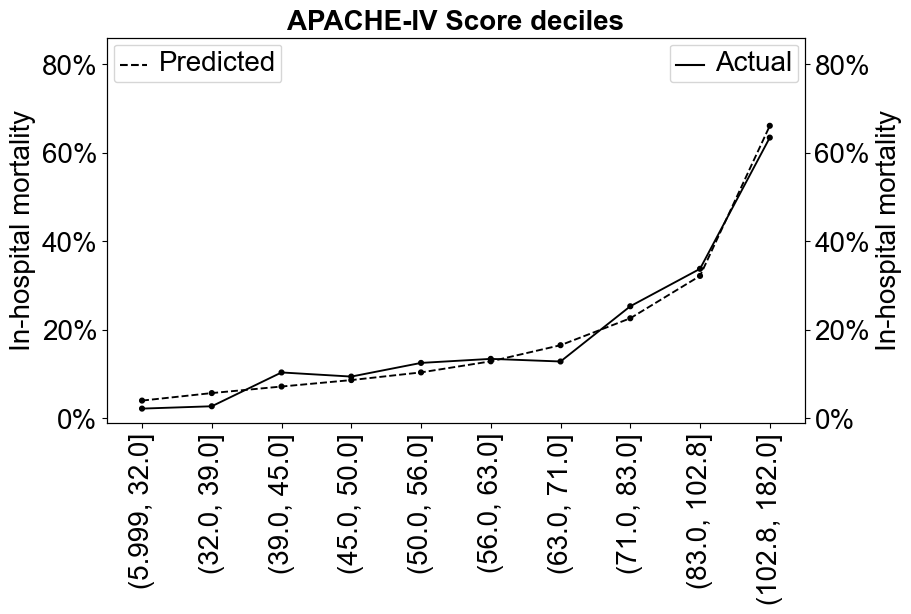

<Figure size 640x480 with 0 Axes>

In [28]:
### Actual vs predicted mortality for the APACHE-IV
# Create a figure and axis
fig_apach, ax1 = plt.subplots(figsize=(9, 5))

# Set the title of the plot
ax1.set_title("APACHE-IV Score deciles", fontsize=20, fontweight="bold")

# Plot the predicted mortality
sns.pointplot(data=df_pe, x="APACHE_score_deciles", y="APACHE_predictions", ax=ax1, errorbar=None, label="Predicted", color="black", linestyles="--", scale=0.5)
ax1.set_xlabel("")
ax1.set_ylabel("In-hospital mortality", fontsize=20)

# Create a twin axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the actual mortality 
sns.pointplot(data=df_pe, x="APACHE_score_deciles", y="hospitaldischargestatus", ax=ax2, errorbar=None, label="Actual", color="black", linestyles="-", scale=0.5)
ax2.set_ylabel("In-hospital mortality", fontsize=20)

# Rotate x-axis labels
for label in ax1.get_xticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
    
# Set font size for y-tick labels
ax1.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

# set the limits for the y axes
ax1.set(ylim=(-0.01, y_ax_upper_lim))
ax2.set(ylim=(-0.01, y_ax_upper_lim))

# change mean in-hospital mortality labels to percent
ax2.yaxis.set_major_formatter(percent_formatter)
ax1.yaxis.set_major_formatter(percent_formatter)

# Create the legend
predicted_line = mlines.Line2D([], [], color='black', linestyle='--', label='Predicted')
actual_line = mlines.Line2D([], [], color='black', linestyle='-', label='Actual')
leg1 = ax1.legend(handles=[predicted_line], loc="upper left")
leg2 = ax2.legend(handles=[actual_line], loc="upper right")

# Set font size for legend
for text in leg1.get_texts():
    text.set_fontsize(20)
for text in leg2.get_texts():
    text.set_fontsize(20)

plt.show()
plt.clf()

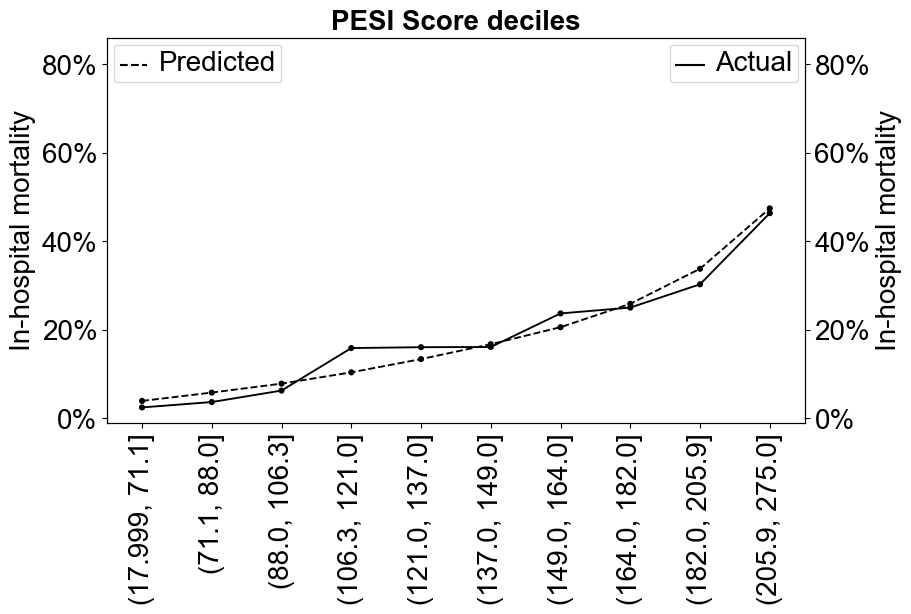

<Figure size 640x480 with 0 Axes>

In [29]:
### Actual vs predicted mortality for the PESI score
# Create a figure and axis
fig_pesi, ax3 = plt.subplots(figsize=(9, 5))

# Set the title of the plot
ax3.set_title("PESI Score deciles", fontsize=20, fontweight="bold")

# Plot the predicted mortality
sns.pointplot(data=df_pe, x="PESI_score_deciles", y="PESI_predictions", ax=ax3, errorbar=None, label="Predicted", color="black", linestyles="--", scale=0.5)
ax3.set_xlabel("")
ax3.set_ylabel("In-hospital mortality", fontsize=20)

# Create a twin axis sharing the same x-axis
ax4 = ax3.twinx()

# Plot the actual mortality 
sns.pointplot(data=df_pe, x="PESI_score_deciles", y="hospitaldischargestatus", ax=ax4, errorbar=None, label="Actual", color="black", linestyles="-", scale=0.5)
ax4.set_ylabel("In-hospital mortality", fontsize=20)

# Rotate x-axis labels
for label in ax3.get_xticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
    
# Set font size for y-tick labels
ax3.tick_params(axis='y', labelsize=20)
ax4.tick_params(axis='y', labelsize=20)
    
# set the limits for the y axes
ax3.set(ylim=(-0.01, y_ax_upper_lim))
ax4.set(ylim=(-0.01, y_ax_upper_lim))

# change mean in-hospital mortality labels to percent
ax4.yaxis.set_major_formatter(percent_formatter)
ax3.yaxis.set_major_formatter(percent_formatter)

# Create the legend
predicted_line = mlines.Line2D([], [], color='black', linestyle='--', label='Predicted')
actual_line = mlines.Line2D([], [], color='black', linestyle='-', label='Actual')
leg1 = ax3.legend(handles=[predicted_line], loc="upper left")
leg2 = ax4.legend(handles=[actual_line], loc="upper right")

# Set font size for legend
for text in leg1.get_texts():
    text.set_fontsize(20)
for text in leg2.get_texts():
    text.set_fontsize(20)


plt.show()
plt.clf()


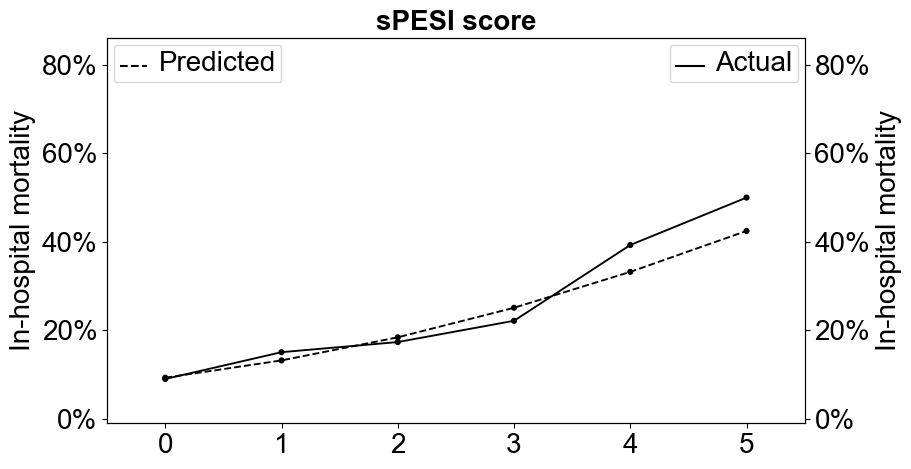

<Figure size 640x480 with 0 Axes>

In [30]:
### Actual vs predicted mortality for the sPESI score
# Create a figure and axis
fig_spesi, ax5 = plt.subplots(figsize=(9, 5))

# Set the title of the plot
ax5.set_title("sPESI score", fontsize=20, fontweight="bold")

# Plot the predicted mortality
sns.pointplot(data=df_pe, x=f"sPESI_score_cat", y="sPESI_predictions", ax=ax5, errorbar=None, label="Predicted", color="black", linestyles="--", scale=0.5)
ax5.set_xlabel("")
ax5.set_ylabel("In-hospital mortality", fontsize=20)

# Create a twin axis sharing the same x-axis
ax6 = ax5.twinx()

# Plot the actual mortality
sns.pointplot(data=df_pe, x=f"sPESI_score_cat", y="hospitaldischargestatus", ax=ax6, errorbar=None, label="Actual", color="black", linestyles="-", scale=0.5)
ax6.set_ylabel("In-hospital mortality", fontsize=20)

# Set font size for y-tick labels
ax5.tick_params(axis='y', labelsize=20)
ax5.tick_params(axis='x', labelsize=20)
ax6.tick_params(axis='y', labelsize=20)
    
# set the limits for the y axes
ax5.set(ylim=(-0.01, y_ax_upper_lim))
ax6.set(ylim=(-0.01, y_ax_upper_lim))

# change mean in-hospital mortality labels to percent
ax6.yaxis.set_major_formatter(percent_formatter)
ax5.yaxis.set_major_formatter(percent_formatter)

# Create the legend
predicted_line = mlines.Line2D([], [], color='black', linestyle='--', label='Predicted')
actual_line = mlines.Line2D([], [], color='black', linestyle='-', label='Actual')
leg1 = ax5.legend(handles=[predicted_line], loc="upper left")
leg2 = ax6.legend(handles=[actual_line], loc="upper right")

# Set font size for legend
for text in leg1.get_texts():
    text.set_fontsize(20)
for text in leg2.get_texts():
    text.set_fontsize(20)

plt.show()
plt.clf()

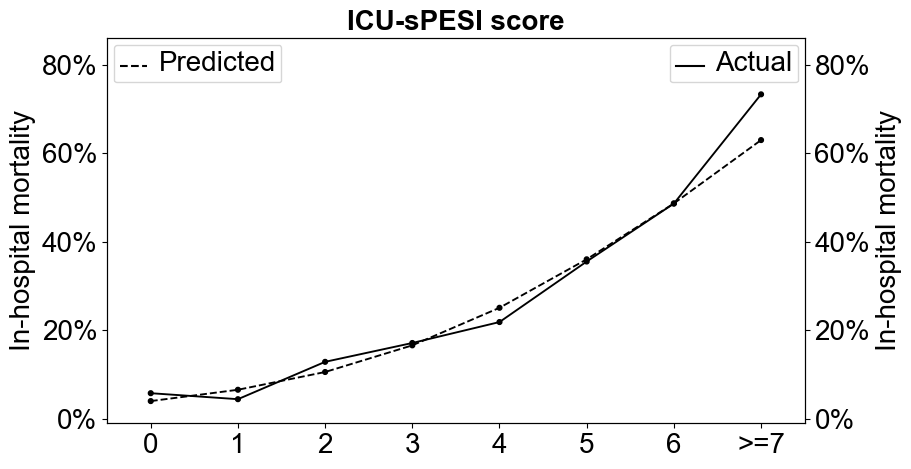

<Figure size 640x480 with 0 Axes>

In [31]:
df_pe[f"ICU_sPESI_score_cat"] = pd.Categorical(df_pe[f"ICU_sPESI_score_cat"], categories=cat_order_ICU_sPESI, ordered=True)

### Actual vs predicted mortality for the ICU-sPESI
# Create a figure and axis
fig_icu_spesi, ax7 = plt.subplots(figsize=(9, 5))

# Set the title of the plot
ax7.set_title("ICU-sPESI score", fontsize=20, fontweight="bold")

# Plot the predicted mortality
sns.pointplot(data=df_pe, x=f"ICU_sPESI_score_cat", y="ICU_sPESI_predictions", ax=ax7, errorbar=None, label="Predicted", color="black", linestyles="--", scale=0.5)
ax7.set_xlabel("")
ax7.set_ylabel("In-hospital mortality", fontsize=20)

# Create a twin axis sharing the same x-axis
ax8 = ax7.twinx()

# Plot the actual mortality
sns.pointplot(data=df_pe, x=f"ICU_sPESI_score_cat", y="hospitaldischargestatus", ax=ax8, errorbar=None, label="Actual", color="black", linestyles="-", scale=0.5)
ax8.set_ylabel("In-hospital mortality", fontsize=20)

# Set font size for y-tick labels
ax7.tick_params(axis='y', labelsize=20)
ax7.tick_params(axis='x', labelsize=20)
ax8.tick_params(axis='y', labelsize=20)
    
# set the limits for the y axes
ax7.set(ylim=(-0.01, y_ax_upper_lim))
ax8.set(ylim=(-0.01, y_ax_upper_lim))

# change mean in-hospital mortality labels to percent
ax8.yaxis.set_major_formatter(percent_formatter)
ax7.yaxis.set_major_formatter(percent_formatter)

# Create the legend
predicted_line = mlines.Line2D([], [], color='black', linestyle='--', label='Predicted')
actual_line = mlines.Line2D([], [], color='black', linestyle='-', label='Actual')
leg1 = ax7.legend(handles=[predicted_line], loc="upper left")
leg2 = ax8.legend(handles=[actual_line], loc="upper right")

# Set font size for legend
for text in leg1.get_texts():
    text.set_fontsize(20)
for text in leg2.get_texts():
    text.set_fontsize(20)

plt.show()
plt.clf()


## ROC curves

### Functions

In [32]:
def calc_AUC_SE(auc, n_pos, n_neg):
    """
    Function to calculate the SE for the AUC of a ROC curve

    :param auc: Float - AUC value
    :param n_pos: Int - number of true positive samples/patients (in total from y true, not the PPV!)
    :param n_neg: Int - number of true negative samples/patients (in total from y true, not the NPV!)
    :return: Float - the standard error for the AUC
    """
    # calculate the standard error of the AUC
    q1 = auc / (2 - auc)
    q2 = (2 * (auc ** 2)) / (1 + auc)

    se_auc = math.sqrt((auc * (1 - auc) + (n_pos - 1) * (q1 - auc ** 2) + (n_neg - 1) * (q2 - auc ** 2)) / (n_pos * n_neg))

    return se_auc


def calc_auc_correlation(auc1, auc2, y_true, test1, test2, kind_scoring="interval"):
    """
    Calculates the correlation of 2 AUCs that are derived from 2 different models on the same data.
    See: Hanley JA, McNeil BJ. A method of comparing the areas under receiver operating characteristic curves derived from the same cases. 
    Radiology. 1983 Sep;148(3):839-43. doi: 10.1148/radiology.148.3.6878708 for more information
    
    :param auc1: Float - AUC value for model 1
    :param auc2: Float - AUC value for model 1
    :param y_true: numpy array - the true labels
    :param test1: numpy array - the array of the score-values of score from the first model
    :param test2: numpy array - the array of the score-values of score from the second model
    :param kind_scoring: String, Picklist either "interval" or "ordinal", default "interval" - whether to use the pearson-r (interval)
        or the kendall-tau (ordinal) to calculate the correlation
    :return: Float - a correlation value
    """
    
    # correlation for the negative patients
    test1_on_neg = test1[y_true == 0]
    test2_on_neg = test2[y_true == 0]

    if kind_scoring == "interval":
        r_neg, p = stats.pearsonr(test1_on_neg, test2_on_neg)
    else:
        r_neg, p = stats.kendalltau(test1_on_neg, test2_on_neg)

    # correlation for the positive patients
    test1_on_true = test1[y_true == 1]
    test2_on_true = test2[y_true == 1]

    if kind_scoring == "interval":
        r_pos, p = stats.pearsonr(test1_on_true, test2_on_true)
    else:
        r_pos, p = stats.kendalltau(test1_on_true, test2_on_true)

    # averages
    auc_av = (auc1 + auc2) / 2
    r_av = (r_neg + r_pos) / 2

    # lookup final r
    dict_r_lookup_paired_auc = {
        "r_average": [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4,
                      0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8,
                      0.82, 0.84, 0.86, 0.88, 0.9],
        0.7: [0.02, 0.04, 0.05, 0.07, 0.09, 0.11, 0.13, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39,
              0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65, 0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.82,
              0.84, 0.86, 0.88],
        0.725: [0.02, 0.04, 0.05, 0.07, 0.09, 0.11, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39,
                0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81,
                0.84, 0.86, 0.88],
        0.75: [0.02, 0.03, 0.05, 0.07, 0.09, 0.11, 0.12, 0.14, 0.16, 0.18, 0.19, 0.21, 0.23, 0.25, 0.27, 0.29, 0.31, 0.32, 0.34, 0.36, 0.38,
               0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.75, 0.77, 0.79, 0.81,
               0.83, 0.86, 0.88],
        0.775: [0.02, 0.03, 0.05, 0.07, 0.09, 0.1, 0.12, 0.14, 0.16, 0.17, 0.19, 0.21, 0.23, 0.25, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38,
                0.4, 0.42, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.79, 0.81,
                0.83, 0.85, 0.88],
        0.8: [0.02, 0.03, 0.05, 0.07, 0.08, 0.1, 0.12, 0.13, 0.15, 0.17, 0.19, 0.21, 0.22, 0.24, 0.26, 0.28, 0.3, 0.31, 0.33, 0.35, 0.37,
              0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65, 0.67, 0.69, 0.72, 0.74, 0.76, 0.78, 0.81,
              0.83, 0.85, 0.87],
        0.825: [0.02, 0.03, 0.05, 0.06, 0.08, 0.1, 0.11, 0.13, 0.15, 0.17, 0.18, 0.2, 0.22, 0.24, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.36,
                0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.65, 0.67, 0.69, 0.71, 0.73, 0.76, 0.78, 0.8,
                0.82, 0.85, 0.87],
        0.85: [0.02, 0.03, 0.05, 0.06, 0.08, 0.09, 0.11, 0.13, 0.14, 0.16, 0.18, 0.19, 0.21, 0.23, 0.25, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36,
               0.38, 0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.71, 0.73, 0.75, 0.77, 0.8,
               0.82, 0.84, 0.87],
        0.875: [0.01, 0.03, 0.04, 0.06, 0.07, 0.09, 0.11, 0.12, 0.14, 0.15, 0.17, 0.19, 0.2, 0.22, 0.24, 0.26, 0.27, 0.29, 0.31, 0.33, 0.35,
                0.37, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.57, 0.59, 0.61, 0.63, 0.65, 0.67, 0.7, 0.72, 0.74, 0.77, 0.79,
                0.81, 0.84, 0.86],
        0.9: [0.01, 0.03, 0.04, 0.06, 0.07, 0.08, 0.1, 0.11, 0.13, 0.15, 0.16, 0.18, 0.19, 0.21, 0.23, 0.24, 0.26, 0.28, 0.3, 0.32, 0.33,
              0.35, 0.37, 0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.6, 0.62, 0.64, 0.66, 0.69, 0.71, 0.73, 0.76, 0.78,
              0.81, 0.83, 0.86],
        0.925: [0.01, 0.02, 0.04, 0.05, 0.06, 0.08, 0.09, 0.11, 0.12, 0.14, 0.15, 0.17, 0.18, 0.2, 0.21, 0.23, 0.25, 0.26, 0.28, 0.3, 0.32,
                0.34, 0.35, 0.37, 0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.54, 0.56, 0.58, 0.6, 0.63, 0.65, 0.67, 0.7, 0.72, 0.75, 0.77,
                0.8, 0.82, 0.85],
        0.95: [0.01, 0.02, 0.03, 0.04, 0.06, 0.07, 0.08, 0.09, 0.11, 0.12, 0.14, 0.15, 0.16, 0.18, 0.19, 0.21, 0.23, 0.24, 0.26, 0.28, 0.29,
               0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.56, 0.58, 0.6, 0.63, 0.65, 0.68, 0.7, 0.73, 0.76,
               0.78, 0.81, 0.84],
        0.975: [0.01, 0.02, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.09, 0.1, 0.11, 0.12, 0.13, 0.15, 0.16, 0.18, 0.19, 0.21, 0.22, 0.24, 0.25,
                0.27, 0.29, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.45, 0.47, 0.49, 0.51, 0.54, 0.56, 0.59, 0.61, 0.64, 0.67, 0.7, 0.73,
                0.75, 0.79, 0.82]
    }
    
    df_r_lookup = pd.DataFrame(dict_r_lookup_paired_auc)
    df_r_lookup = df_r_lookup.set_index("r_average")

    index_array = df_r_lookup.index.to_numpy()
    clms_array = df_r_lookup.columns.to_numpy()
    
    # look for the value closest to the calculated r value
    final_r = df_r_lookup.at[index_array[np.abs(index_array - r_av).argmin()], clms_array[np.abs(clms_array - auc_av).argmin()]]

    return final_r


def compare_AUCs_paired(auc1, auc2, y_true, test1, test2, kind_scoring="interval"):
    """
    Compare 2 AUCs which are derived from 2 different models on the same data.
    Derived from: Hanley JA, McNeil BJ. A method of comparing the areas under receiver operating characteristic curves derived from the same cases. 
    Radiology. 1983 Sep;148(3):839-43. doi: 10.1148/radiology.148.3.6878708 for more information
    

    :param auc1: Float - AUC value for model 1
    :param auc2: Float - AUC value for model 1
    :param y_true: numpy array - the true labels
    :param test1: numpy array - the array of the score-values of score from the first model
    :param test2: numpy array - the array of the score-values of score from the second model
    :param kind_scoring: String, Picklist either "interval" or "ordinal", default "interval" - whether to use the pearson-r (interval)
        or the kendall-tau (ordinal) to calculate the correlation
    :return: Float - p value
    """
    
    # count the number of true positives and true negatives
    n_pos = np.count_nonzero(y_true == 1)
    n_neg = np.count_nonzero(y_true == 0)
    
    # calculate the standard errors of the AUROCs
    se_auc1 = calc_AUC_SE(auc1, n_pos, n_neg)
    se_auc2 = calc_AUC_SE(auc2, n_pos, n_neg)

    # calculate the correlation of these AUROCs (as they are derived from the same patient cohort)
    r_aucs = calc_auc_correlation(auc1, auc2, y_true, test1, test2, kind_scoring=kind_scoring)
    
    # adjust the standard error for the correlation
    se_auc1_vs_auc2 = math.sqrt(se_auc1 ** 2 + se_auc2 ** 2 - 2 * r_aucs * se_auc1 * se_auc2)
    
    # calculate the p-value of the comparison
    z_stat = (auc1 - auc2) / se_auc1_vs_auc2
    p_value = stats.norm.sf(abs(z_stat)) * 2

    return p_value


def compare_AUCs_independent(auc1, auc2, y_true1, y_true2):
    """
    Compare 2 independent AUCs (as in 2 different models on 2 differen patient populations)  models on the same data statistically.
    
    :param auc1: Float - AUC value for model 1
    :param auc2: Float - AUC value for model 1
    :param y_true1: numpy array - the true labels
    :param y_true2: numpy array - the true labels
    :return: p-value
    """
    # count the number of true positives and true negatives
    n_pos1 = np.count_nonzero(y_true1 == 1)
    n_neg1 = np.count_nonzero(y_true1 == 0)
    
    # count the number of true positives and true negatives
    n_pos2 = np.count_nonzero(y_true2 == 1)
    n_neg2 = np.count_nonzero(y_true2 == 0)

    # calculate the standard errors of the AUROCs
    se_auc1 = calc_AUC_SE(auc1, n_pos1, n_neg1)
    se_auc2 = calc_AUC_SE(auc2, n_pos2, n_neg2)

    # calculate the standard error of the AUROCs
    se_auc1_vs_auc2 = math.sqrt(se_auc1 ** 2 + se_auc2 ** 2)

    # calculate the p-value of the comparison
    z_stat = (auc1 - auc2) / se_auc1_vs_auc2
    p_value = stats.norm.sf(abs(z_stat)) * 2

    return p_value

In [33]:
def calc_spec(threshold, y_true, pred):
    """
    Calculate the specificity for a vector of predictions at a certain threshold

    :param threshold: Float - threshold as to where the labels (0/1) should be split/decided for the predictions
    :param y_true: Numpy array - 1d, containing the true outcomes
    :param pred: Numpy array - numpy array of the predictions (percentages!)
    :return: specificity (Float)
    """
    
    pred_labels = np.where(pred > threshold, 1, 0)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, pred_labels).ravel()

    if tn == 0 or (tn + fp) == 0:
        return 0

    spec = tn / (tn + fp)

    return spec


def calc_sens(threshold, y_true, pred):
    """
    Calculate the sensitivity for a vector of predictions at a certain threshold

    :param threshold: Float - threshold as to where the labels (0/1) should be split/decided for the predictions
    :param y_true: Numpy array - 1d, containing the true outcomes
    :param pred: Numpy array - numpy array of the predictions (percentages!)
    :return: sensitivity (Float)
    """
    pred_labels = np.where(pred > threshold, 1, 0)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, pred_labels).ravel()

    if tp == 0 or (tp + fn) == 0:
        return 0

    sens = tp / (tp + fn)

    return sens


def calc_ppv(threshold, y_true, pred):
    """
    Calculate the positive predictive value (PPV) for a vector of predictions at a certain threshold

    :param threshold: Float - threshold as to where the labels (0/1) should be split/decided for the predictions
    :param y_true: Numpy array - 1d, containing the true outcomes
    :param pred: Numpy array - numpy array of the predictions (percentages!)
    :return: positive predictive value (Float)
    """
    pred_labels = np.where(pred > threshold, 1, 0)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, pred_labels).ravel()

    if tp == 0 or (tp + fp) == 0:
        return 0

    ppv = tp / (tp + fp)

    return ppv


def calc_npv(threshold, y_true, pred):
    """
    Calculate the negative predictive value (NPV) for a prediction at a certain threshold

    :param threshold: Float - threshold as to where the labels (0/1) should be split/decided for the predictions
    :param y_true: Numpy array - 1d, containing the true outcomes
    :param pred: Numpy array - numpy array of the predictions (percentages!)
    :return: negative predictive value (Float)
    """
    pred_labels = np.where(pred > threshold, 1, 0)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, pred_labels).ravel()

    if tn == 0 or (tn + fn) == 0:
        return 0

    npv = tn / (tn + fn)

    return npv

### Plotting and comparisons

AUROC for the APACHE IV is: 0.79042


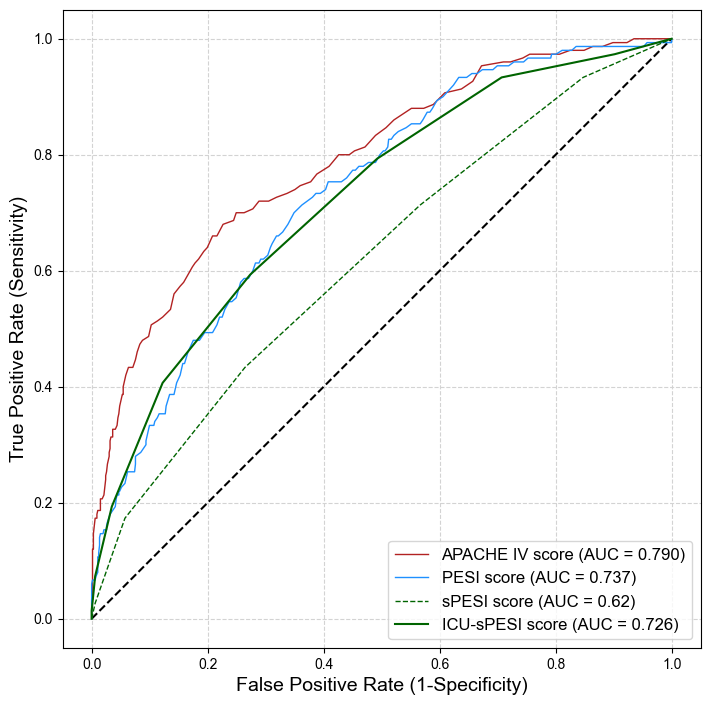

<Figure size 640x480 with 0 Axes>

In [34]:
# initialize the plots
plt.rc('legend', fontsize = 12)
fig, ax_roc_hosp = plt.subplots(1, 1, figsize=(7,7))

ax_roc_hosp.plot([0, 1], [0, 1], "k--")

# vector of the true outcome
np_temp_outcome = df_pe["hospitaldischargestatus"].copy().to_numpy()

# vector of the true outcome
np_temp_outcome = df_pe["hospitaldischargestatus"].to_numpy()

# APACHE-IV
np_temp_apache_score_raw = df_pe.apachescore.to_numpy()
fpr_apache, tpr_apache, _ = metrics.roc_curve(np_temp_outcome, np_temp_apache_score_raw)
auc_apache = metrics.roc_auc_score(np_temp_outcome, np_temp_apache_score_raw)

# PESI Score 
np_temp_pesi_score_raw = df_pe[f"PESI_score"].to_numpy()
fpr_pesi, tpr_pesi, _ = metrics.roc_curve(np_temp_outcome, np_temp_pesi_score_raw)
auc_pesi = metrics.roc_auc_score(np_temp_outcome, np_temp_pesi_score_raw)

# sPESI score
np_temp_spesi_score_raw = df_pe[f"sPESI_score"].to_numpy()
fpr_spesi, tpr_spesi, _ = metrics.roc_curve(np_temp_outcome, np_temp_spesi_score_raw)
auc_spesi = metrics.roc_auc_score(np_temp_outcome, np_temp_spesi_score_raw)

# ICU-sPESI score
np_temp_icu_spesi_raw = df_pe[f"ICU_sPESI_score"].to_numpy()
fpr_icu_spesi, tpr_icu_spesi, _ = metrics.roc_curve(np_temp_outcome, np_temp_icu_spesi_raw)
auc_icu_spesi = metrics.roc_auc_score(np_temp_outcome, np_temp_icu_spesi_raw)

print(f"AUROC for the APACHE IV is: {round(auc_apache, 5)}")

# ROC curves
ax_roc_hosp.plot(
    fpr_apache, 
    tpr_apache, 
    label="APACHE IV score (AUC = 0.790)", # do this as the round function will cut it at 0.79
    c="firebrick",
    lw=1
)

ax_roc_hosp.plot(
    fpr_pesi, 
    tpr_pesi, 
    label="PESI score (AUC = {})".format(round(auc_pesi, 3)),
    c="dodgerblue",
    lw=1
)

ax_roc_hosp.plot(
    fpr_spesi, 
    tpr_spesi, 
    label="sPESI score (AUC = {})".format(round(auc_spesi, 3)),
    c="darkgreen",
    lw=1,
    linestyle="--"
)

ax_roc_hosp.plot(
    fpr_icu_spesi, 
    tpr_icu_spesi, 
    label="ICU-sPESI score (AUC = {})".format(round(auc_icu_spesi, 3)),
    c="darkgreen",
    lw=1.5
)


ax_roc_hosp.set_xlabel("False Positive Rate (1-Specificity)", fontsize=14)
ax_roc_hosp.set_ylabel("True Positive Rate (Sensitivity)", fontsize=14)
ax_roc_hosp.grid(color='lightgray', linestyle='dashed')
ax_roc_hosp.axis("square")

# Adding the legend
leg = ax_roc_hosp.legend(loc="lower right")

plt.tight_layout(pad=0.4, w_pad=0, h_pad=4.0)

plt.show()
plt.clf()

### Comparing the AUROC

In [35]:
# calculate the p-values for the comparison of the various AUROC
# "ordinal" correlation is used for any comparison involving the sPESI or ICU-sPESI
p_val_apache_pesi = compare_AUCs_paired(auc1=auc_apache, 
                                        auc2=auc_pesi, 
                                        y_true=np_temp_outcome, 
                                        test1=np_temp_apache_score_raw, 
                                        test2=np_temp_pesi_score_raw, 
                                        kind_scoring="interval")

p_val_apache_spesi = compare_AUCs_paired(auc1=auc_apache, 
                                        auc2=auc_spesi, 
                                        y_true=np_temp_outcome, 
                                        test1=np_temp_apache_score_raw, 
                                        test2=np_temp_spesi_score_raw, 
                                        kind_scoring="ordinal")

p_val_pesi_spesi = compare_AUCs_paired(auc1=auc_pesi, 
                                       auc2=auc_spesi, 
                                       y_true=np_temp_outcome, 
                                       test1=np_temp_pesi_score_raw, 
                                       test2=np_temp_spesi_score_raw, 
                                       kind_scoring="ordinal")

p_val_apache_icu_spesi = compare_AUCs_paired(auc1=auc_apache, 
                                             auc2=auc_icu_spesi, 
                                             y_true=np_temp_outcome, 
                                             test1=np_temp_apache_score_raw, 
                                             test2=np_temp_icu_spesi_raw, 
                                             kind_scoring="ordinal")

p_val_pesi_icu_spesi = compare_AUCs_paired(auc1=auc_pesi, 
                                           auc2=auc_icu_spesi, 
                                           y_true=np_temp_outcome, 
                                           test1=np_temp_pesi_score_raw, 
                                           test2=np_temp_icu_spesi_raw, 
                                           kind_scoring="ordinal")

p_val_spesi_icu_spesi = compare_AUCs_paired(auc1=auc_spesi, 
                                            auc2=auc_icu_spesi, 
                                            y_true=np_temp_outcome, 
                                            test1=np_temp_spesi_score_raw, 
                                            test2=np_temp_icu_spesi_raw, 
                                            kind_scoring="ordinal")

print("p-value APACHE-IV vs PESI: {}".format(round(p_val_apache_pesi, 4)))
print("p-value APACHE-IV vs sPESI: {}".format(round(p_val_apache_spesi, 4)))
print("p-value PESI vs sPESI: {}".format(round(p_val_pesi_spesi, 4)))
print("p-value APACHE-IV vs ICU-sPESI: {}".format(round(p_val_apache_icu_spesi, 4)))
print("p-value PESI vs ICU-sPESI: {}".format(round(p_val_pesi_icu_spesi, 4)))
print("p-value sPESI vs ICU-sPESI: {}".format(round(p_val_spesi_icu_spesi, 4)))

p-value APACHE-IV vs PESI: 0.0406
p-value APACHE-IV vs sPESI: 0.0
p-value PESI vs sPESI: 0.0
p-value APACHE-IV vs ICU-sPESI: 0.0218
p-value PESI vs ICU-sPESI: 0.6052
p-value sPESI vs ICU-sPESI: 0.0


## Survival Curves

### Kaplan-Meier Analysis

In [36]:
df_pe['time_to_death_unitadmit'].describe()

count    150.000000
mean       9.627224
std       13.790502
min        0.200600
25%        1.687342
50%        6.248572
75%       11.664025
max      124.195800
Name: time_to_death_unitadmit, dtype: float64

In [37]:
df_pe['time_to_death_unitadmit'].nlargest(5)

768    124.195800
794     55.327072
256     54.260400
276     40.237494
749     33.763156
Name: time_to_death_unitadmit, dtype: float64

In [38]:
# replace np.nan with 55 in the time_to_death_unitadmit column (assuming that patient survived post-hospitaldischarge) 
df_pe['time_to_death_kaplan'] = df_pe['time_to_death_unitadmit'].replace(np.nan, 55)

#### PESI classes

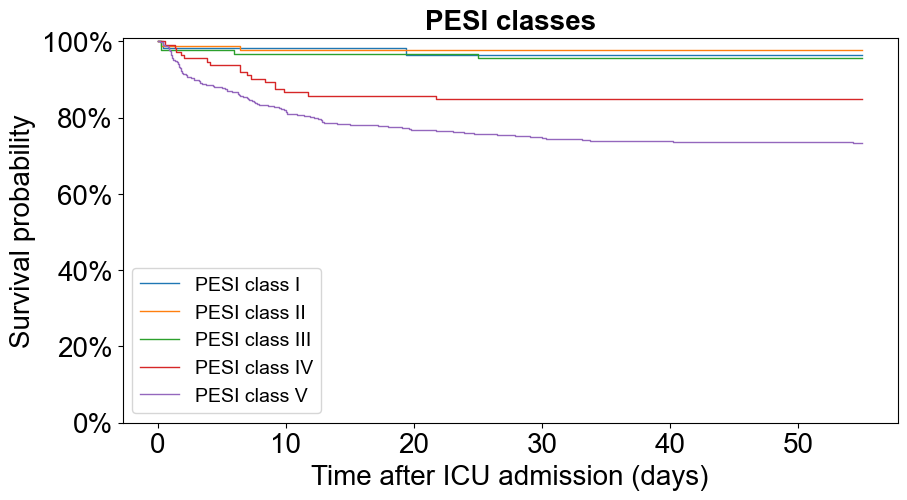

<Figure size 640x480 with 0 Axes>

In [39]:
### Kaplan-Meier estimated curvival curves for the PESI classes
# split into groups based on the PESI classes
group1 = df_pe[df_pe[f'PESI_class'] == 1]
group2 = df_pe[df_pe[f'PESI_class'] == 2]
group3 = df_pe[df_pe[f'PESI_class'] == 3]
group4 = df_pe[df_pe[f'PESI_class'] == 4]
group5 = df_pe[df_pe[f'PESI_class'] == 5]

# initiate the KaplanMeierFitter
kmf = KaplanMeierFitter()

# create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# fit the model for each group and plot the survival function
kmf.fit(group1['time_to_death_kaplan'], event_observed=group1['hospitaldischargestatus'], label='PESI class I')
kmf.plot(ax=ax1, ci_show=False, loc=slice(0,55), linewidth=1.0)

kmf.fit(group2['time_to_death_kaplan'], event_observed=group2['hospitaldischargestatus'], label='PESI class II')
kmf.plot(ax=ax1, ci_show=False, loc=slice(0,55), linewidth=1.0)

kmf.fit(group3['time_to_death_kaplan'], event_observed=group3['hospitaldischargestatus'], label='PESI class III')
kmf.plot(ax=ax1, ci_show=False, loc=slice(0,55), linewidth=1.0)

kmf.fit(group4['time_to_death_kaplan'], event_observed=group4['hospitaldischargestatus'], label='PESI class IV')
kmf.plot(ax=ax1, ci_show=False, loc=slice(0,55), linewidth=1.0)

kmf.fit(group5['time_to_death_kaplan'], event_observed=group5['hospitaldischargestatus'], label='PESI class V')
kmf.plot(ax=ax1, ci_show=False, loc=slice(0,55), linewidth=1.0)

ax1.set_xlabel('Time after ICU admission (days)', fontsize=20)
ax1.set_ylabel('Survival probability', fontsize=20)
ax1.set(ylim=(0.0,1.01))

ax1.yaxis.set_major_formatter(percent_formatter)

plt.title("PESI classes", fontsize=20, fontweight='bold')

# Set font size for y-tick labels
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

# decrease size of legend and move it to the lower left to not cover the lowest survival curve
plt.legend(prop={'size': 14}, loc='lower left')

plt.show()
plt.clf()

In [40]:
### Log rank tests for the PESI classes survival curves
# add the times and events of the groups
event_times = pd.concat([group1['time_to_death_kaplan'], group2['time_to_death_kaplan'], group3['time_to_death_kaplan'], group4['time_to_death_kaplan'], group5['time_to_death_kaplan']])
event_observed = pd.concat([group1['hospitaldischargestatus'], group2['hospitaldischargestatus'], group3['hospitaldischargestatus'], group4['hospitaldischargestatus'], group5['hospitaldischargestatus']])

# create an array for group labels
groups = pd.concat([pd.Series(np.repeat(1, len(group1))), pd.Series(np.repeat(2, len(group2))), pd.Series(np.repeat(3, len(group3))), pd.Series(np.repeat(4, len(group4))), pd.Series(np.repeat(5, len(group5)))])

# perform the multivariate log-rank test
results = multivariate_logrank_test(event_durations=event_times, groups=groups, event_observed=event_observed)
print(f'p-value from multivariate log-rank test: {results.p_value}')

# list of groups/names
groups = [group1, group2, group3, group4, group5]
group_names = ['PESI class I', 'PESI class II', 'PESI class III', 'PESI class IV', 'PESI class V']

# perform pairwise log-rank tests, adjusting the p-value via Bonferroni-correction (multiplying the p-value by the number of individual pairwise comparisons)
for (i, groupA), (j, groupB) in combinations(enumerate(groups), 2):
    results = logrank_test(groupA['time_to_death_kaplan'], groupB['time_to_death_kaplan'], event_observed_A=groupA['hospitaldischargestatus'], event_observed_B=groupB['hospitaldischargestatus'])
    print(f'Log-rank test p-value for {group_names[i]} vs {group_names[j]}: {round(results.p_value*len(list(combinations(groups, 2))), 4)}')

p-value from multivariate log-rank test: 1.977538676199758e-11
Log-rank test p-value for PESI class I vs PESI class II: 6.6809
Log-rank test p-value for PESI class I vs PESI class III: 7.6088
Log-rank test p-value for PESI class I vs PESI class IV: 0.2315
Log-rank test p-value for PESI class I vs PESI class V: 0.0023
Log-rank test p-value for PESI class II vs PESI class III: 4.155
Log-rank test p-value for PESI class II vs PESI class IV: 0.0213
Log-rank test p-value for PESI class II vs PESI class V: 0.0
Log-rank test p-value for PESI class III vs PESI class IV: 0.1429
Log-rank test p-value for PESI class III vs PESI class V: 0.0001
Log-rank test p-value for PESI class IV vs PESI class V: 0.1442


#### sPESI score

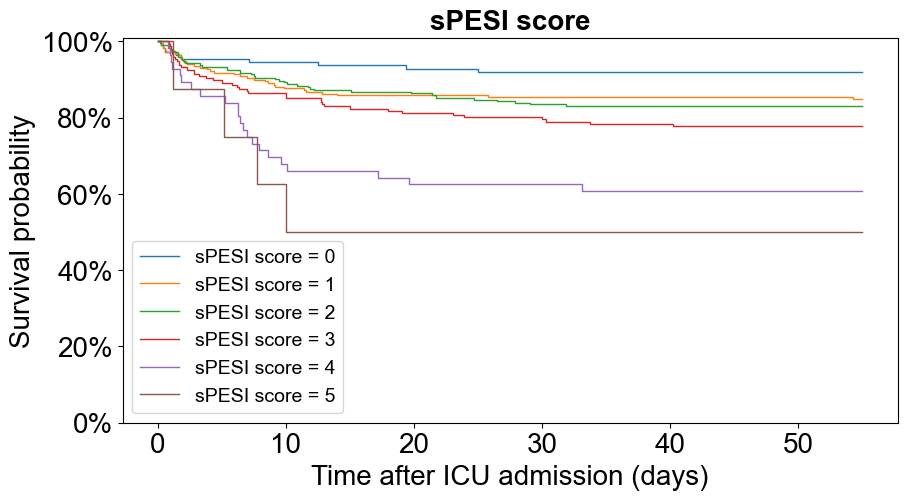

<Figure size 640x480 with 0 Axes>

In [41]:
### Kaplan-Meier estimated curvival curves for the sPESI score
# split into groups based on the sPESI score
group0 = df_pe[df_pe[f'sPESI_score'] == 0]
group1 = df_pe[df_pe[f'sPESI_score'] == 1]
group2 = df_pe[df_pe[f'sPESI_score'] == 2]
group3 = df_pe[df_pe[f'sPESI_score'] == 3]
group4 = df_pe[df_pe[f'sPESI_score'] == 4]
group5 = df_pe[df_pe[f'sPESI_score'] >= 5]

# initiate the KaplanMeierFitter
kmf = KaplanMeierFitter()

# create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# fit the model for each group and plot the survival function
kmf.fit(group0['time_to_death_kaplan'], event_observed=group0['hospitaldischargestatus'], label='sPESI score = 0')
kmf.plot(ax=ax1, ci_show=False, loc=slice(0,55), linewidth=1.0)

kmf.fit(group1['time_to_death_kaplan'], event_observed=group1['hospitaldischargestatus'], label='sPESI score = 1')
kmf.plot(ax=ax1, ci_show=False, loc=slice(0,55), linewidth=1.0)

kmf.fit(group2['time_to_death_kaplan'], event_observed=group2['hospitaldischargestatus'], label='sPESI score = 2')
kmf.plot(ax=ax1, ci_show=False, loc=slice(0,55), linewidth=1.0)

kmf.fit(group3['time_to_death_kaplan'], event_observed=group3['hospitaldischargestatus'], label='sPESI score = 3')
kmf.plot(ax=ax1, ci_show=False, loc=slice(0,55), linewidth=1.0)

kmf.fit(group4['time_to_death_kaplan'], event_observed=group4['hospitaldischargestatus'], label='sPESI score = 4')
kmf.plot(ax=ax1, ci_show=False, loc=slice(0,55), linewidth=1.0)

kmf.fit(group5['time_to_death_kaplan'], event_observed=group5['hospitaldischargestatus'], label='sPESI score = 5')
kmf.plot(ax=ax1, ci_show=False, loc=slice(0,55), linewidth=1.0)

ax1.set_xlabel('Time after ICU admission (days)', fontsize=20)
ax1.set_ylabel('Survival probability', fontsize=20)
ax1.set(ylim=(0.0,1.01))

ax1.yaxis.set_major_formatter(percent_formatter)

plt.title("sPESI score", fontsize=20, fontweight='bold')

# Set font size for y-tick labels
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

# decrease size of legend and move it to the lower left to not cover the lowest survival curve
plt.legend(prop={'size': 14}, loc='lower left')

plt.show()
plt.clf()

In [42]:
### Log rank tests for the sPESI score survival curves
# add the times and events of the groups
event_times = pd.concat([group0['time_to_death_kaplan'], group1['time_to_death_kaplan'], group2['time_to_death_kaplan'], group3['time_to_death_kaplan'], group4['time_to_death_kaplan'], group5['time_to_death_kaplan']])
event_observed = pd.concat([group0['hospitaldischargestatus'], group1['hospitaldischargestatus'], group2['hospitaldischargestatus'], group3['hospitaldischargestatus'], group4['hospitaldischargestatus'], group5['hospitaldischargestatus']])

# create an array for group labels
groups = pd.concat([pd.Series(np.repeat(0, len(group0))), pd.Series(np.repeat(1, len(group1))), pd.Series(np.repeat(2, len(group2))), pd.Series(np.repeat(3, len(group3))), pd.Series(np.repeat(4, len(group4))), pd.Series(np.repeat(5, len(group5)))])

# perform the multivariate log-rank test
results = multivariate_logrank_test(event_durations=event_times, groups=groups, event_observed=event_observed)
print(f'p-value from multivariate log-rank test: {results.p_value}')

# list of groups/names
groups = [group0, group1, group2, group3, group4, group5]
group_names = ['sPESI score 0', 'sPESI score 1', 'sPESI score 2', 'sPESI score 3', 'sPESI score 4', 'sPESI score 5']

# perform pairwise log-rank tests, adjusting the p-value via Bonferroni-correction (multiplying the p-value by the number of individual pairwise comparisons)
for (i, groupA), (j, groupB) in combinations(enumerate(groups), 2):
    results = logrank_test(groupA['time_to_death_kaplan'], groupB['time_to_death_kaplan'], event_observed_A=groupA['hospitaldischargestatus'], event_observed_B=groupB['hospitaldischargestatus'])
    print(f'Log-rank test p-value for {group_names[i]} vs {group_names[j]}: {round(results.p_value*len(list(combinations(groups, 2))), 4)}')

p-value from multivariate log-rank test: 7.111358024060724e-07
Log-rank test p-value for sPESI score 0 vs sPESI score 1: 1.161
Log-rank test p-value for sPESI score 0 vs sPESI score 2: 0.3405
Log-rank test p-value for sPESI score 0 vs sPESI score 3: 0.036
Log-rank test p-value for sPESI score 0 vs sPESI score 4: 0.0
Log-rank test p-value for sPESI score 0 vs sPESI score 5: 0.001
Log-rank test p-value for sPESI score 1 vs sPESI score 2: 9.4717
Log-rank test p-value for sPESI score 1 vs sPESI score 3: 1.1971
Log-rank test p-value for sPESI score 1 vs sPESI score 4: 0.0005
Log-rank test p-value for sPESI score 1 vs sPESI score 5: 0.0727
Log-rank test p-value for sPESI score 2 vs sPESI score 3: 2.6524
Log-rank test p-value for sPESI score 2 vs sPESI score 4: 0.0012
Log-rank test p-value for sPESI score 2 vs sPESI score 5: 0.0946
Log-rank test p-value for sPESI score 3 vs sPESI score 4: 0.1288
Log-rank test p-value for sPESI score 3 vs sPESI score 5: 0.6858
Log-rank test p-value for sPESI s

#### ICU-sPESI classes

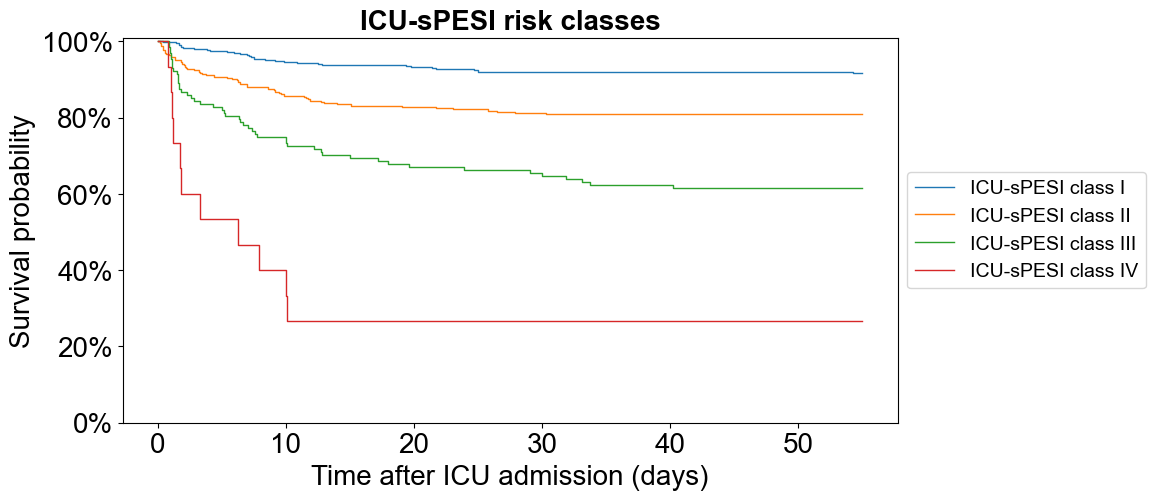

<Figure size 640x480 with 0 Axes>

In [43]:
### Kaplan-Meier estimated curvival curves (with 95% CI) for the proposed ICU-sPESI classes
# split into groups based on the ICU-sPESI score
group0 = df_pe[df_pe[f'ICU_sPESI_score'] <=2]
group1 = df_pe[(df_pe[f'ICU_sPESI_score'] == 3) | (df_pe[f'ICU_sPESI_score'] == 4)]
group2 = df_pe[(df_pe[f'ICU_sPESI_score'] == 5) | (df_pe[f'ICU_sPESI_score'] == 6)]
group3 = df_pe[df_pe[f'ICU_sPESI_score'] >= 7]

# initiate the KaplanMeierFitter
kmf = KaplanMeierFitter()

# create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# fit the model for each group and plot the survival function
kmf.fit(group0['time_to_death_kaplan'], event_observed=group0['hospitaldischargestatus'], label='ICU-sPESI class I')
kmf.plot(ax=ax1, ci_show=False, ci_alpha=0.2, loc=slice(0,55), linewidth=1.0)

kmf.fit(group1['time_to_death_kaplan'], event_observed=group1['hospitaldischargestatus'], label='ICU-sPESI class II')
kmf.plot(ax=ax1, ci_show=False, ci_alpha=0.2, loc=slice(0,55), linewidth=1.0)

kmf.fit(group2['time_to_death_kaplan'], event_observed=group2['hospitaldischargestatus'], label='ICU-sPESI class III')
kmf.plot(ax=ax1, ci_show=False, ci_alpha=0.2, loc=slice(0,55), linewidth=1.0)

kmf.fit(group3['time_to_death_kaplan'], event_observed=group3['hospitaldischargestatus'], label='ICU-sPESI class IV')
kmf.plot(ax=ax1, ci_show=False, ci_alpha=0.2, loc=slice(0,55), linewidth=1.0)

ax1.set_xlabel('Time after ICU admission (days)', fontsize=20)
ax1.set_ylabel('Survival probability', fontsize=20)
ax1.set(ylim=(0.0,1.01))

ax1.yaxis.set_major_formatter(percent_formatter)

plt.title("ICU-sPESI risk classes", fontsize=20, fontweight='bold')


# move the legend to the right of the plot
plt.legend(prop={'size': 14}, loc='center left', bbox_to_anchor=(1, 0.5))

# Set font size for y-tick labels
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

plt.show()
plt.clf()

In [44]:
### Log rank tests for the proposed ICU-sPESI classes survival curves
# add the times and events of the groups
event_times = pd.concat([group0['time_to_death_kaplan'], group1['time_to_death_kaplan'], group2['time_to_death_kaplan'], group3['time_to_death_kaplan']])
event_observed = pd.concat([group0['hospitaldischargestatus'], group1['hospitaldischargestatus'], group2['hospitaldischargestatus'], group3['hospitaldischargestatus']])

# create an array for group labels
groups = pd.concat([pd.Series(np.repeat(0, len(group0))), pd.Series(np.repeat(1, len(group1))), pd.Series(np.repeat(2, len(group2))), pd.Series(np.repeat(3, len(group3)))])

# perform the multivariate log-rank test
results = multivariate_logrank_test(event_durations=event_times, groups=groups, event_observed=event_observed)
print(f'p-value from multivariate log-rank test: {results.p_value}')

# list of groups/names
groups = [group0, group1, group2, group3]
group_names = ['ICU-sPESI score <=2', 'ICU-sPESI score 3-4', 'ICU-sPESI score 5-6', 'ICU-sPESI score >= 7']

# perform pairwise log-rank tests
for (i, groupA), (j, groupB) in combinations(enumerate(groups), 2):
    results = logrank_test(groupA['time_to_death_kaplan'], groupB['time_to_death_kaplan'], event_observed_A=groupA['hospitaldischargestatus'], event_observed_B=groupB['hospitaldischargestatus'])
    print(f'Log-rank test p-value for {group_names[i]} vs {group_names[j]}: {round(results.p_value*len(list(combinations(groups, 2))), 4)}')

p-value from multivariate log-rank test: 6.187670824528782e-26
Log-rank test p-value for ICU-sPESI score <=2 vs ICU-sPESI score 3-4: 0.0001
Log-rank test p-value for ICU-sPESI score <=2 vs ICU-sPESI score 5-6: 0.0
Log-rank test p-value for ICU-sPESI score <=2 vs ICU-sPESI score >= 7: 0.0
Log-rank test p-value for ICU-sPESI score 3-4 vs ICU-sPESI score 5-6: 0.0001
Log-rank test p-value for ICU-sPESI score 3-4 vs ICU-sPESI score >= 7: 0.0
Log-rank test p-value for ICU-sPESI score 5-6 vs ICU-sPESI score >= 7: 0.005
